## Result Analysis

In [1]:
from glob import glob
import json
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
report_files = glob('../models/reports/*.json')
print(f"Number of report files: {len(report_files)}")

Number of report files: 703


In [3]:
protein_to_uniprot = json.load(open('../protein_to_uniprot.json', 'r'))
uniprot_to_protein = json.load(open('../uniprot_to_protein_name.json', 'r'))

In [4]:
model_names= []

In [5]:
metrics = ['accuracy', 'f1_score', 'cohen_kappa', 'mcc']
models = ['xgb', 'rf', 'svc', 'ann']
data_metrics = ['train_count', 'test_count', 'actives_count', 'decoys_count']
report = dict()

for _file in report_files:
    # Strip the model name
    _dir, _model_name = os.path.split(_file)
    model_name = os.path.splitext(_model_name)[0][:6]
    
    # Load the dictionary
    _dict = json.load(open(_file, 'r'))
    model_names.append(model_name)
    
    # Extract the metrics
    _report = [round(_dict[model][metric], 4) for model in models for metric in metrics]
    
    # Find the best model
    best_metric = 'f1_score'
    scores = np.array([_dict[model][best_metric] for model in models])
        
    best_model = models[np.argmax(scores)]
    best_score = round(np.max(scores), 4)
    _data_info = [_dict['xgb']['data_info'][c] for c in data_metrics] # Picked a random model e.g., xgb for data info
    report[model_name] = _report + _data_info + [best_model, best_metric, best_score]
    #break

report_df = pd.DataFrame.from_dict(report, orient='index')
report_df.columns = [f"{model}_{metric}" for model in models for metric in metrics] + data_metrics + ['best_model', 'best_metric', 'best_score']

In [6]:
report_df.head(5)

,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,svc_f1_score,...,ann_f1_score,ann_cohen_kappa,ann_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
O00141,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.9818,0.8900,0.8900,440,110,50,500,xgb,f1_score,1.0000
O00206,0.9583,0.9559,0.8333,0.8452,1.0000,1.0000,1.0000,1.0000,0.9583,0.9601,...,0.9601,0.8636,0.8718,96,24,20,100,rf,f1_score,1.0000
O00255,0.9815,0.9805,0.8789,0.8854,0.9815,0.9805,0.8789,0.8854,0.9907,0.9909,...,0.9587,0.7313,0.7593,431,108,49,490,svc,f1_score,0.9909
O00311,0.9918,0.9911,0.8195,0.8332,0.9991,0.9991,0.9826,0.9827,0.9973,0.9973,...,0.9962,0.9267,0.9292,4410,1103,149,5364,rf,f1_score,0.9991
O00329,0.9890,0.9889,0.9318,0.9324,0.9882,0.9879,0.9249,0.9268,0.9873,0.9874,...,0.9899,0.9389,0.9389,4734,1184,538,5380,ann,f1_score,0.9899


best_model
ann    114
rf     238
svc    154
xgb    197
dtype: int64


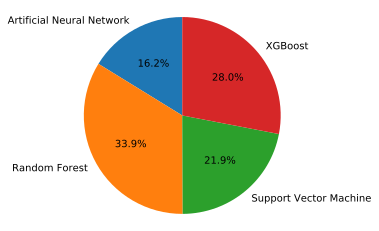

In [7]:
count = report_df.groupby('best_model').size()
print(count)
fig1, ax1 = plt.subplots()
ax1.pie(count, 
        autopct = '%1.1f%%',
        startangle = 90,
        labels = ['Artificial Neural Network', 'Random Forest', 'Support Vector Machine', 'XGBoost'])
ax1.axis('equal')
plt.savefig('plots/model_pie', dpi=300)
plt.show()

In [8]:
report_df.groupby('best_metric').size()

best_metric
f1_score    703
dtype: int64

In [9]:
# Load json file containing the uniprot ids and their corresponding family name
with open('../uniprot_to_family_name.json', 'r') as json_file:
    data = json.loads(json_file.read())

In [10]:
# Create list of family name of each uniprot
family = []
for i in range(len(report_df)):
    uniprot = report_df.index[i]
    for key in data.keys():
        if uniprot in data[key]:
            family.append(key)
    else:
        continue
        
# Insert the family info to existing dataframe.
report_df.insert(0,'protein_family',family)
report_df.to_csv('Report.csv')

In [11]:
report_df.head()

,protein_family,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,...,ann_f1_score,ann_cohen_kappa,ann_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
O00141,Kinase,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.9818,0.8900,0.8900,440,110,50,500,xgb,f1_score,1.0000
O00206,Other,0.9583,0.9559,0.8333,0.8452,1.0000,1.0000,1.0000,1.0000,0.9583,...,0.9601,0.8636,0.8718,96,24,20,100,rf,f1_score,1.0000
O00255,Other,0.9815,0.9805,0.8789,0.8854,0.9815,0.9805,0.8789,0.8854,0.9907,...,0.9587,0.7313,0.7593,431,108,49,490,svc,f1_score,0.9909
O00311,Kinase,0.9918,0.9911,0.8195,0.8332,0.9991,0.9991,0.9826,0.9827,0.9973,...,0.9962,0.9267,0.9292,4410,1103,149,5364,rf,f1_score,0.9991
O00329,Kinase,0.9890,0.9889,0.9318,0.9324,0.9882,0.9879,0.9249,0.9268,0.9873,...,0.9899,0.9389,0.9389,4734,1184,538,5380,ann,f1_score,0.9899


In [12]:
report_df.groupby('best_model')['protein_family'].value_counts()

best_model  protein_family
ann         Enzyme            44
            Kinase            26
            GPCR              25
            IC                 6
            Epigenetic         5
            Other              5
            NR                 2
            TF; Epigenetic     1
rf          Enzyme            81
            GPCR              42
            Kinase            40
            Other             31
            IC                16
            Epigenetic        14
            NR                 8
            Transporter        5
            TF                 1
svc         Enzyme            55
            Kinase            38
            GPCR              21
            Other             19
            Epigenetic         5
            NR                 5
            IC                 4
            Transporter        4
            TF                 2
            TF; Epigenetic     1
xgb         Enzyme            79
            GPCR              37
            Kina

In [13]:
family_counts = report_df.groupby('best_model')['protein_family'].value_counts()
family_counts.to_csv('model_family_counts.csv')

/home/mhassan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


### Violin plots

In [14]:
# report_df = pd.read_csv('Report.csv')
models = ['rf', 'xgb', 'svc', 'ann']
metrics = ['Accuracy','F1_Score', 'Cohen_Kappa', 'MCC']

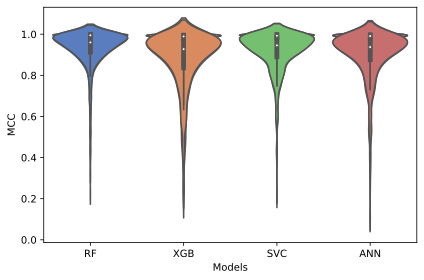

In [15]:
for i in metrics:
    data = []
    for j in models:
        data.append(list(report_df[j+'_'+i.lower()]))
    ax = sns.violinplot(data= (data), palette="muted",scale='width')
    ax.set_xlabel('Models')
    if i == 'F1_Score' or 'Cohen_Kappa': i = ' '.join(i.split('_'))
    ax.set_ylabel(i)
    ax.set_xticklabels([m.upper() for m in models])
    plt.rc('xtick', labelsize = 16 )
    plt.rc('ytick', labelsize = 16)
    plt.rcParams["axes.labelsize"] = 16
    plt.tight_layout()
    plt.savefig('plots/'+i.lower(),dpi=300)

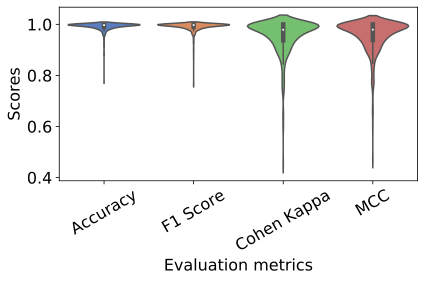

In [9]:
# Violin plot of best scores obtained by different metrics
final_score = []
for me in metrics:
    score = []
    for m in best_models:
        for i in range(len(report_df)):
            if report_df['best_model'][i]==m:
                s=report_df[m+'_'+me.lower()][i]
                score.append(s)
    final_score.append(score)
new_metrics = ['Accuracy', 'F1 Score', 'Cohen Kappa', 'MCC']
ax = sns.violinplot(data= (final_score), palette="muted",scale='width')
ax.set_xlabel('Evaluation metrics')
ax.set_ylabel('Scores')
ax.set_xticklabels(new_metrics)
plt.xticks(rotation=30)
plt.rc('xtick', labelsize = 16 )
plt.rc('ytick', labelsize = 16)
plt.rcParams["axes.labelsize"] = 16
plt.tight_layout()
#     plt.show()
plt.savefig('plots/'+'metrics_performance.png',dpi=600)

In [16]:
df = pd.read_csv('model_family_counts.csv', names=['model', 'protein_family', 'count'])
df.head()

,model,protein_family,count
0,ann,Enzyme,44
1,ann,Kinase,26
2,ann,GPCR,25
3,ann,IC,6
4,ann,Epigenetic,5


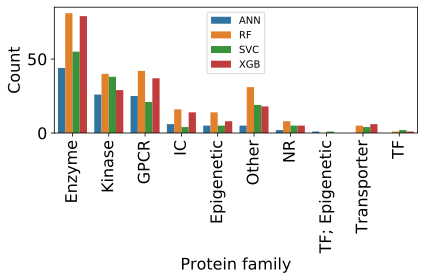

In [17]:
# plt.Figure(figsize=(20, 5))
ax = sns.barplot('protein_family', 'count', 'model', data = df)
ax.set_xlabel('Protein family')
ax.set_ylabel('Count')
ax.legend(loc='upper right')

new_labels=['ANN', 'RF', 'SVC', 'XGB']
for t, l in zip(ax.legend().get_texts(), new_labels):
    t.set_text(l)

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('plots/model_count', dpi=300)
plt.show()

In [18]:
report_df.head()

,protein_family,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,...,ann_f1_score,ann_cohen_kappa,ann_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
O00141,Kinase,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.9818,0.8900,0.8900,440,110,50,500,xgb,f1_score,1.0000
O00206,Other,0.9583,0.9559,0.8333,0.8452,1.0000,1.0000,1.0000,1.0000,0.9583,...,0.9601,0.8636,0.8718,96,24,20,100,rf,f1_score,1.0000
O00255,Other,0.9815,0.9805,0.8789,0.8854,0.9815,0.9805,0.8789,0.8854,0.9907,...,0.9587,0.7313,0.7593,431,108,49,490,svc,f1_score,0.9909
O00311,Kinase,0.9918,0.9911,0.8195,0.8332,0.9991,0.9991,0.9826,0.9827,0.9973,...,0.9962,0.9267,0.9292,4410,1103,149,5364,rf,f1_score,0.9991
O00329,Kinase,0.9890,0.9889,0.9318,0.9324,0.9882,0.9879,0.9249,0.9268,0.9873,...,0.9899,0.9389,0.9389,4734,1184,538,5380,ann,f1_score,0.9899


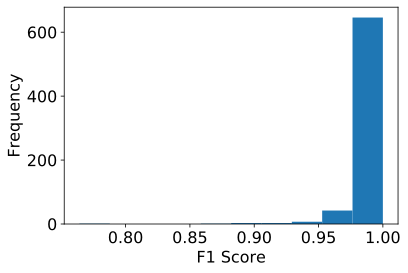

In [19]:
ax = report_df['best_score'].hist(grid=False)
ax.set_xlabel('F1 Score')
ax.set_ylabel('Frequency')
plt.savefig('plots/f1_score_freq.png', dpi=600)
plt.show()